In [1]:
#!/usr/bin/env python
# coding: utf-8

import gym
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import random
import statistics
import time 

from torch import nn
from tqdm import tqdm
from scipy.optimize import minimize_scalar

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  
        self.fc2 = nn.Linear(64, output_dim) 

        # Apply the weights initialization
        self.apply(self.init_weights)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def act(self, state):
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = self.forward(state_t.unsqueeze(0))  
        max_q_index = torch.argmax(q_values, dim=1)[0]   
        action = max_q_index.detach().item()   
        return action  

    def init_weights(self, m):
        if type(m) == nn.Linear:
            init.xavier_normal_(m.weight)
            # init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def inject_parameters(self, pvec):
        new_state_dict = {}
        count = 0
        for name, param in self.named_parameters():
            sz = param.data.numel()
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.data.shape)
            new_state_dict[name] = torch.from_numpy(reshaped).float()
            count += sz
        self.load_state_dict(new_state_dict)

In [3]:
def calculate_fitness(network, env, num_episodes):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward, _

def select_survivors(population, fitnesses, ELITISM):
    sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
    return sorted_population[:ELITISM]

def tournament_selection(population, fitnesses, tournament_size):
    selected_indices = np.random.randint(len(population), size=tournament_size)
    selected_fitnesses = [fitnesses[i] for i in selected_indices]
    winner_index = selected_indices[np.argmax(selected_fitnesses)]
    return population[winner_index]

def perturb_parameters(network, weight_clip, n_episodes):

    for episode in range(n_episodes):
        # Reset the environment
        state = env.reset()
        done = False
        total_reward = 0
        current_output = None

        while not done:

            if episode == 0 and current_output is None:
                prev_output = torch.Tensor([0.5, 0.5])
            else:
                prev_output = current_output.detach()

            # Get the original parameters
            current_param = torch.cat([param.view(-1) for param in network.parameters()])

            # Perturb the model parameters
            delta = torch.randn_like(current_param)

            # Forward pass to calculate the output
            current_output = network(torch.from_numpy(state).float().unsqueeze(0))

            # Calculate the error
            error = ((current_output - prev_output)**2).mean()

            # Clear the gradients from the last backward pass
            network.zero_grad()

            # Backward pass to calculate the gradients
            error.backward()

            # Extract the gradients
            gradient = torch.cat([param.grad.view(-1) for param in network.parameters()])

            # Normalize the gradients
            gradient /= ((gradient**2).sum() + 1e-10)

            # Calculate the new parameters
            perturbation = np.clip(delta * gradient, -weight_clip, weight_clip)
            new_param = current_param + perturbation

            # Inject the new parameters into the model
            network.inject_parameters(new_param.detach().numpy())

            action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
            state, reward, done, _ = env.step(action)

In [4]:
# Constants
POPULATION_SIZE = 50
GENERATIONS = 150
ELITISM = int(POPULATION_SIZE * 0.4)
TOURNAMENT_SIZE = 5
WEIGHT_CLIP = 0.2
INPUT_DIM = 4  # For CartPole environment
OUTPUT_DIM = 2  # For CartPole environment
MAX_EP = 1

FITNESS_HISTORY = list()
FITNESS_STDERROR_HISTORY = list()

env = gym.make("CartPole-v1")

# Creating initial population of networks
population = [PolicyNetwork(INPUT_DIM, OUTPUT_DIM) for _ in range(POPULATION_SIZE)]

/Users/jinhyunpark/miniforge3/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
start_time = time.time()

In [6]:
# Generations loop
for generation in range(GENERATIONS):
    print(f"[Generation {generation}]")
    
    # Calculate fitness for each network
    print("Calculating Fitnesses For Population ...")
    fitnesses = [calculate_fitness(network, env, MAX_EP) for network in tqdm(population)]
    
    avg_fitness = np.average(fitnesses)
    max_fitness = np.max(fitnesses)
    min_fitness = np.min(fitnesses)
    FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
    
    # std error
    standard_deviation = statistics.stdev(fitnesses)
    standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
    FITNESS_STDERROR_HISTORY.append(standard_error)
    
    print(f"Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")

    # Select the best networks to pass their genes to the next generation
    survivors = select_survivors(population, fitnesses, ELITISM)

    # Create the next generation
    next_population = survivors  # Start with the survivors
    
    print("Generating Offsprings ...")
    # Add offspring by tournament selection and mutation
    for _ in tqdm(range(POPULATION_SIZE - len(survivors))):
        parent = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
        offspring = copy.deepcopy(parent)

        # Perturb the offspring using your approach
        perturb_parameters(offspring, WEIGHT_CLIP, MAX_EP)

        next_population.append(offspring)

    # The next generation becomes the current population
    population = next_population

[Generation 0]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1218.08it/s]


Average Fitness: 29.0 
 Best Fitness: 271.0 
 Worst Fitness: 8.0 
 Standard Error: 5.850867718657165
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 258.14it/s]


[Generation 1]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1153.73it/s]


Average Fitness: 32.88 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 10.169889129088832
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 257.66it/s]


[Generation 2]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1609.84it/s]


Average Fitness: 23.4 
 Best Fitness: 115.0 
 Worst Fitness: 8.0 
 Standard Error: 3.4635124321051505
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 279.50it/s]


[Generation 3]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 887.68it/s]


Average Fitness: 43.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 11.083309385683298
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 273.38it/s]


[Generation 4]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1273.66it/s]


Average Fitness: 28.9 
 Best Fitness: 119.0 
 Worst Fitness: 8.0 
 Standard Error: 4.258796419033846
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 267.85it/s]


[Generation 5]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 794.43it/s]


Average Fitness: 48.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 11.336578326958506
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 241.35it/s]


[Generation 6]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1046.49it/s]


Average Fitness: 35.1 
 Best Fitness: 291.0 
 Worst Fitness: 8.0 
 Standard Error: 6.845838897029467
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 269.90it/s]


[Generation 7]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.13it/s]


Average Fitness: 35.56 
 Best Fitness: 158.0 
 Worst Fitness: 8.0 
 Standard Error: 5.438123926202371
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 254.26it/s]


[Generation 8]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1141.45it/s]


Average Fitness: 32.88 
 Best Fitness: 150.0 
 Worst Fitness: 8.0 
 Standard Error: 4.9182409332556105
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 218.87it/s]


[Generation 9]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1146.84it/s]


Average Fitness: 32.92 
 Best Fitness: 164.0 
 Worst Fitness: 8.0 
 Standard Error: 4.851832391068389
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 256.27it/s]


[Generation 10]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 838.93it/s]


Average Fitness: 44.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 10.909881310265554
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 215.35it/s]


[Generation 11]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 853.90it/s]


Average Fitness: 44.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 10.870829343350254
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 225.84it/s]


[Generation 12]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1125.96it/s]


Average Fitness: 34.12 
 Best Fitness: 150.0 
 Worst Fitness: 9.0 
 Standard Error: 4.702204433094359
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 248.84it/s]


[Generation 13]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 921.80it/s]


Average Fitness: 41.38 
 Best Fitness: 321.0 
 Worst Fitness: 8.0 
 Standard Error: 7.495788749664163
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 205.76it/s]


[Generation 14]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1083.82it/s]


Average Fitness: 35.76 
 Best Fitness: 168.0 
 Worst Fitness: 8.0 
 Standard Error: 5.75681034133681
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 203.15it/s]


[Generation 15]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.74it/s]


Average Fitness: 48.16 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 10.739716866256156
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 215.29it/s]


[Generation 16]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 968.88it/s]


Average Fitness: 39.54 
 Best Fitness: 165.0 
 Worst Fitness: 8.0 
 Standard Error: 5.4332468587918425
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 180.52it/s]


[Generation 17]
Calculating Fitnesses For Population ...


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1077.80it/s]


Average Fitness: 36.12 
 Best Fitness: 162.0 
 Worst Fitness: 8.0 
 Standard Error: 5.1044310482688084
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 192.62it/s]


[Generation 18]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 875.72it/s]


Average Fitness: 43.88 
 Best Fitness: 157.0 
 Worst Fitness: 8.0 
 Standard Error: 5.794623827835803
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 181.53it/s]


[Generation 19]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 952.55it/s]


Average Fitness: 40.86 
 Best Fitness: 166.0 
 Worst Fitness: 8.0 
 Standard Error: 5.731617287877294
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 183.42it/s]


[Generation 20]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 710.10it/s]


Average Fitness: 54.66 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 11.077891569818377
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 147.57it/s]


[Generation 21]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 728.87it/s]


Average Fitness: 53.6 
 Best Fitness: 166.0 
 Worst Fitness: 8.0 
 Standard Error: 6.755919551000577
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 154.86it/s]


[Generation 22]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 855.84it/s]


Average Fitness: 44.84 
 Best Fitness: 157.0 
 Worst Fitness: 8.0 
 Standard Error: 6.09237462500695
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 184.12it/s]


[Generation 23]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 762.55it/s]


Average Fitness: 51.18 
 Best Fitness: 176.0 
 Worst Fitness: 8.0 
 Standard Error: 7.291241041027744
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 123.70it/s]


[Generation 24]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 733.63it/s]


Average Fitness: 53.08 
 Best Fitness: 155.0 
 Worst Fitness: 8.0 
 Standard Error: 6.576758087293124
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 146.04it/s]


[Generation 25]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 776.75it/s]


Average Fitness: 50.32 
 Best Fitness: 157.0 
 Worst Fitness: 8.0 
 Standard Error: 6.282755147616208
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 135.74it/s]


[Generation 26]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 717.96it/s]


Average Fitness: 53.9 
 Best Fitness: 150.0 
 Worst Fitness: 9.0 
 Standard Error: 6.3012308483407935
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.46it/s]


[Generation 27]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 633.09it/s]


Average Fitness: 61.5 
 Best Fitness: 192.0 
 Worst Fitness: 8.0 
 Standard Error: 6.9632416799848
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.79it/s]


[Generation 28]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 628.99it/s]


Average Fitness: 62.16 
 Best Fitness: 153.0 
 Worst Fitness: 9.0 
 Standard Error: 6.629640307908484
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 171.58it/s]


[Generation 29]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 688.62it/s]


Average Fitness: 56.38 
 Best Fitness: 192.0 
 Worst Fitness: 9.0 
 Standard Error: 7.281617335483111
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 143.35it/s]


[Generation 30]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 678.79it/s]


Average Fitness: 55.62 
 Best Fitness: 196.0 
 Worst Fitness: 8.0 
 Standard Error: 7.517158060472218
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 128.34it/s]


[Generation 31]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.93it/s]


Average Fitness: 62.78 
 Best Fitness: 405.0 
 Worst Fitness: 9.0 
 Standard Error: 10.110099617991619
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 122.81it/s]


[Generation 32]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 573.19it/s]


Average Fitness: 66.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 11.16112056403379
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.23it/s]


[Generation 33]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 517.96it/s]


Average Fitness: 73.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 11.687069778177934
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.83it/s]


[Generation 34]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 488.97it/s]


Average Fitness: 79.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 11.340403117047597
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.55it/s]


[Generation 35]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.89it/s]


Average Fitness: 77.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 12.846829196660288
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.72it/s]


[Generation 36]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 460.64it/s]


Average Fitness: 84.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 14.40748359962521
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.35it/s]


[Generation 37]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 492.89it/s]


Average Fitness: 78.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 14.30435954668423
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.35it/s]


[Generation 38]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 441.91it/s]


Average Fitness: 87.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 14.453963795020213
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.64it/s]


[Generation 39]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.76it/s]


Average Fitness: 87.98 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 14.3522874519026
Generating Offsprings ...


100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.15it/s]


[Generation 40]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 457.97it/s]


Average Fitness: 85.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 14.248852155703702
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.86it/s]


[Generation 41]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 420.38it/s]


Average Fitness: 92.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 14.82078656096613
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.30it/s]


[Generation 42]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.02it/s]


Average Fitness: 106.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 14.710801529238747
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.24it/s]


[Generation 43]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 392.91it/s]


Average Fitness: 97.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 14.123305388684365
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.45it/s]


[Generation 44]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 376.68it/s]


Average Fitness: 102.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 14.355775627863197
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.26it/s]


[Generation 45]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 374.05it/s]


Average Fitness: 105.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 14.089973276723256
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.83it/s]


[Generation 46]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 407.99it/s]


Average Fitness: 95.74 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 14.810443364499971
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.35it/s]


[Generation 47]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 370.96it/s]


Average Fitness: 106.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 14.771616743758612
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.65it/s]


[Generation 48]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 356.07it/s]


Average Fitness: 109.6 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 14.312831406019663
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.70it/s]


[Generation 49]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 355.99it/s]


Average Fitness: 109.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 14.828583539769344
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.35it/s]


[Generation 50]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 346.15it/s]


Average Fitness: 113.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 15.568157192402284
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.42it/s]


[Generation 51]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 362.03it/s]


Average Fitness: 108.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 16.32933231573021
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.33it/s]


[Generation 52]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 293.22it/s]


Average Fitness: 129.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 17.13805289823955
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.75it/s]


[Generation 53]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 294.36it/s]


Average Fitness: 132.4 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 16.033332626189754
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.28it/s]


[Generation 54]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 310.27it/s]


Average Fitness: 126.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 16.67725421534568
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.93it/s]


[Generation 55]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 289.62it/s]


Average Fitness: 135.42 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 16.599928448333625
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.62it/s]


[Generation 56]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 272.47it/s]


Average Fitness: 144.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 17.660498063099315
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.93it/s]


[Generation 57]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 264.45it/s]


Average Fitness: 148.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 18.294872929599812
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.37it/s]


[Generation 58]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 275.93it/s]


Average Fitness: 143.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 18.24442749701611
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.82it/s]


[Generation 59]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 260.38it/s]


Average Fitness: 147.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 16.752450688828564
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.59it/s]


[Generation 60]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 238.25it/s]


Average Fitness: 165.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 17.645572723340376
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.75it/s]


[Generation 61]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 228.58it/s]


Average Fitness: 168.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 20.175402481886756
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.74it/s]


[Generation 62]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 197.26it/s]


Average Fitness: 200.06 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 20.384496109363436
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.72it/s]


[Generation 63]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 232.02it/s]


Average Fitness: 170.4 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 22.05634713590607
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.16it/s]


[Generation 64]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.97it/s]


Average Fitness: 205.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 24.480929687561847
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.28it/s]


[Generation 65]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 192.10it/s]


Average Fitness: 199.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 23.377499036990457
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.98it/s]


[Generation 66]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.10it/s]


Average Fitness: 210.86 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 21.9597407144278
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.13it/s]


[Generation 67]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 202.89it/s]


Average Fitness: 193.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 23.526489629473293
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.16it/s]


[Generation 68]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 201.81it/s]


Average Fitness: 194.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 23.33369727607326
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.48it/s]


[Generation 69]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.84it/s]


Average Fitness: 180.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 23.213410796699534
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.94it/s]


[Generation 70]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.49it/s]


Average Fitness: 207.88 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 24.228733826949004
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.07it/s]


[Generation 71]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 202.36it/s]


Average Fitness: 195.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 22.07182412960386
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.33it/s]


[Generation 72]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.14it/s]


Average Fitness: 210.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 24.234268871890936
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.66it/s]


[Generation 73]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 190.02it/s]


Average Fitness: 207.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.0631074510333
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.77it/s]


[Generation 74]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.51it/s]


Average Fitness: 212.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 24.460808136565674
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.81it/s]


[Generation 75]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.76it/s]


Average Fitness: 217.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 26.08543404637452
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.69it/s]


[Generation 76]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.68it/s]


Average Fitness: 212.86 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 25.060775270187815
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.70it/s]


[Generation 77]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.56it/s]


Average Fitness: 218.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.381987667619406
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.23it/s]


[Generation 78]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.89it/s]


Average Fitness: 223.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 26.125470565042423
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.52it/s]


[Generation 79]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.88it/s]


Average Fitness: 226.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 26.92420578481113
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.70it/s]


[Generation 80]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.58it/s]


Average Fitness: 209.32 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 26.198542411550225
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.09it/s]


[Generation 81]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.37it/s]


Average Fitness: 224.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.687409648813745
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.52it/s]


[Generation 82]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.92it/s]


Average Fitness: 212.94 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 26.74876934037321
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.02it/s]


[Generation 83]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.98it/s]


Average Fitness: 230.48 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 26.156393685144078
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.32it/s]


[Generation 84]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.31it/s]


Average Fitness: 214.86 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.005335980664476
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.07it/s]


[Generation 85]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.88it/s]


Average Fitness: 215.68 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 24.397698787435854
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.18it/s]


[Generation 86]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.09it/s]


Average Fitness: 233.48 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 25.403795956108443
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.15it/s]


[Generation 87]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.16it/s]


Average Fitness: 243.72 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 25.13431738090537
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.36it/s]


[Generation 88]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.62it/s]


Average Fitness: 243.98 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 26.032311006257792
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.66it/s]


[Generation 89]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.62it/s]


Average Fitness: 270.46 
 Best Fitness: 500.0 
 Worst Fitness: 19.0 
 Standard Error: 24.316572160414655
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.66it/s]


[Generation 90]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.14it/s]


Average Fitness: 223.9 
 Best Fitness: 500.0 
 Worst Fitness: 18.0 
 Standard Error: 26.032322922372753
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.29it/s]


[Generation 91]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.29it/s]


Average Fitness: 240.88 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 27.775611677902482
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.80it/s]


[Generation 92]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.74it/s]


Average Fitness: 232.28 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 27.71811519934358
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.83it/s]


[Generation 93]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.26it/s]


Average Fitness: 267.66 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 26.508629476732548
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.79it/s]


[Generation 94]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 183.09it/s]


Average Fitness: 214.64 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 26.815054559340506
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.07it/s]


[Generation 95]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.52it/s]


Average Fitness: 246.76 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 26.481715833181724
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.27it/s]


[Generation 96]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.07it/s]


Average Fitness: 246.8 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 29.02072447372036
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.45it/s]


[Generation 97]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.50it/s]


Average Fitness: 234.5 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 29.351455827329477
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.66it/s]


[Generation 98]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.55it/s]


Average Fitness: 257.78 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.974503781562078
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.90it/s]


[Generation 99]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.57it/s]


Average Fitness: 233.26 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 28.776433243264904
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.91it/s]


[Generation 100]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.36it/s]


Average Fitness: 248.46 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 28.81071526855441
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.98it/s]


[Generation 101]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.10it/s]


Average Fitness: 260.24 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 28.3374643487078
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.79it/s]


[Generation 102]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 142.56it/s]


Average Fitness: 269.72 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 27.3936688648591
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.34it/s]


[Generation 103]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.57it/s]


Average Fitness: 239.06 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 28.935430015883323
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.72it/s]


[Generation 104]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.21it/s]


Average Fitness: 246.14 
 Best Fitness: 500.0 
 Worst Fitness: 19.0 
 Standard Error: 27.43316940627658
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.36it/s]


[Generation 105]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.27it/s]


Average Fitness: 263.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.864928087029554
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.96it/s]


[Generation 106]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.03it/s]


Average Fitness: 239.2 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 29.883433401079177
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.94it/s]


[Generation 107]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.69it/s]


Average Fitness: 244.68 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 28.928433015541888
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.52it/s]


[Generation 108]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.63it/s]


Average Fitness: 250.82 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 29.127933013392024
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.10it/s]


[Generation 109]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.71it/s]


Average Fitness: 254.26 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 28.508728487956102
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.44it/s]


[Generation 110]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.01it/s]


Average Fitness: 265.78 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 27.986925373051157
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.45it/s]


[Generation 111]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.42it/s]


Average Fitness: 256.28 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 26.99921450104557
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.89it/s]


[Generation 112]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.40it/s]


Average Fitness: 250.14 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 29.073980372385847
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.80it/s]


[Generation 113]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.69it/s]


Average Fitness: 265.86 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.864016295981642
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.17it/s]


[Generation 114]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.24it/s]


Average Fitness: 229.2 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 30.549137400561204
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.78it/s]


[Generation 115]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.24it/s]


Average Fitness: 264.02 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 27.570369927862476
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.50it/s]


[Generation 116]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.09it/s]


Average Fitness: 235.96 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 29.85885107895315
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.41it/s]


[Generation 117]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.44it/s]


Average Fitness: 253.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.271341420772444
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.99it/s]


[Generation 118]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.70it/s]


Average Fitness: 239.98 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.436430930790745
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.49it/s]


[Generation 119]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.95it/s]


Average Fitness: 243.96 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.919415033024414
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.20it/s]


[Generation 120]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.97it/s]


Average Fitness: 250.66 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 29.369380278773058
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.50it/s]


[Generation 121]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.28it/s]


Average Fitness: 264.8 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 29.52750360913965
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.34it/s]


[Generation 122]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.30it/s]


Average Fitness: 260.3 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 28.7122280712648
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.08it/s]


[Generation 123]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.77it/s]


Average Fitness: 253.36 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 28.809759684197722
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.53it/s]


[Generation 124]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 132.95it/s]


Average Fitness: 287.96 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 29.829952896307404
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]


[Generation 125]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.99it/s]


Average Fitness: 254.1 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 29.358477550473097
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.44it/s]


[Generation 126]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 142.11it/s]


Average Fitness: 278.82 
 Best Fitness: 500.0 
 Worst Fitness: 18.0 
 Standard Error: 29.78299322959809
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.64it/s]


[Generation 127]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.55it/s]


Average Fitness: 253.7 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 28.197629803418092
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.36it/s]


[Generation 128]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 141.01it/s]


Average Fitness: 280.52 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 29.20872444447839
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.01it/s]


[Generation 129]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.16it/s]


Average Fitness: 255.2 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 29.94556966993854
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.24it/s]


[Generation 130]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.84it/s]


Average Fitness: 261.48 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 29.743903371196964
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.26it/s]


[Generation 131]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.80it/s]


Average Fitness: 271.78 
 Best Fitness: 500.0 
 Worst Fitness: 18.0 
 Standard Error: 28.75751245238328
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.96it/s]


[Generation 132]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.95it/s]


Average Fitness: 251.76 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 29.982288104812813
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.60it/s]


[Generation 133]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.20it/s]


Average Fitness: 264.28 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.316806352225296
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.79it/s]


[Generation 134]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.69it/s]


Average Fitness: 266.64 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 28.644275134120317
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.15it/s]


[Generation 135]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.43it/s]


Average Fitness: 235.46 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 29.251760247052147
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.44it/s]


[Generation 136]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.10it/s]


Average Fitness: 229.24 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 30.327418186808302
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.46it/s]


[Generation 137]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.76it/s]


Average Fitness: 246.16 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 27.878941800548443
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.22it/s]


[Generation 138]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.66it/s]


Average Fitness: 266.08 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 27.989850055376305
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]


[Generation 139]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.00it/s]


Average Fitness: 253.16 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 28.216703115245007
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.74it/s]


[Generation 140]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.13it/s]


Average Fitness: 265.4 
 Best Fitness: 500.0 
 Worst Fitness: 17.0 
 Standard Error: 29.819401984175965
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.34it/s]


[Generation 141]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 142.23it/s]


Average Fitness: 271.96 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 28.34746448727192
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.40it/s]


[Generation 142]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.84it/s]


Average Fitness: 263.22 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 28.959821428020874
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.35it/s]


[Generation 143]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.22it/s]


Average Fitness: 259.54 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 28.94608936965265
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.75it/s]


[Generation 144]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.56it/s]


Average Fitness: 248.88 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 30.240959384414307
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.93it/s]


[Generation 145]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.71it/s]


Average Fitness: 265.18 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.519391040240013
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.05it/s]


[Generation 146]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.82it/s]


Average Fitness: 260.2 
 Best Fitness: 500.0 
 Worst Fitness: 17.0 
 Standard Error: 28.817936591431298
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.08it/s]


[Generation 147]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 140.47it/s]


Average Fitness: 281.24 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 28.27716407568597
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.52it/s]


[Generation 148]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.14it/s]


Average Fitness: 253.06 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 29.287434235207982
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.42it/s]


[Generation 149]
Calculating Fitnesses For Population ...


100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.21it/s]


Average Fitness: 272.58 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 29.30403733415641
Generating Offsprings ...


100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.40it/s]


In [7]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 126.89778780937195 seconds ---


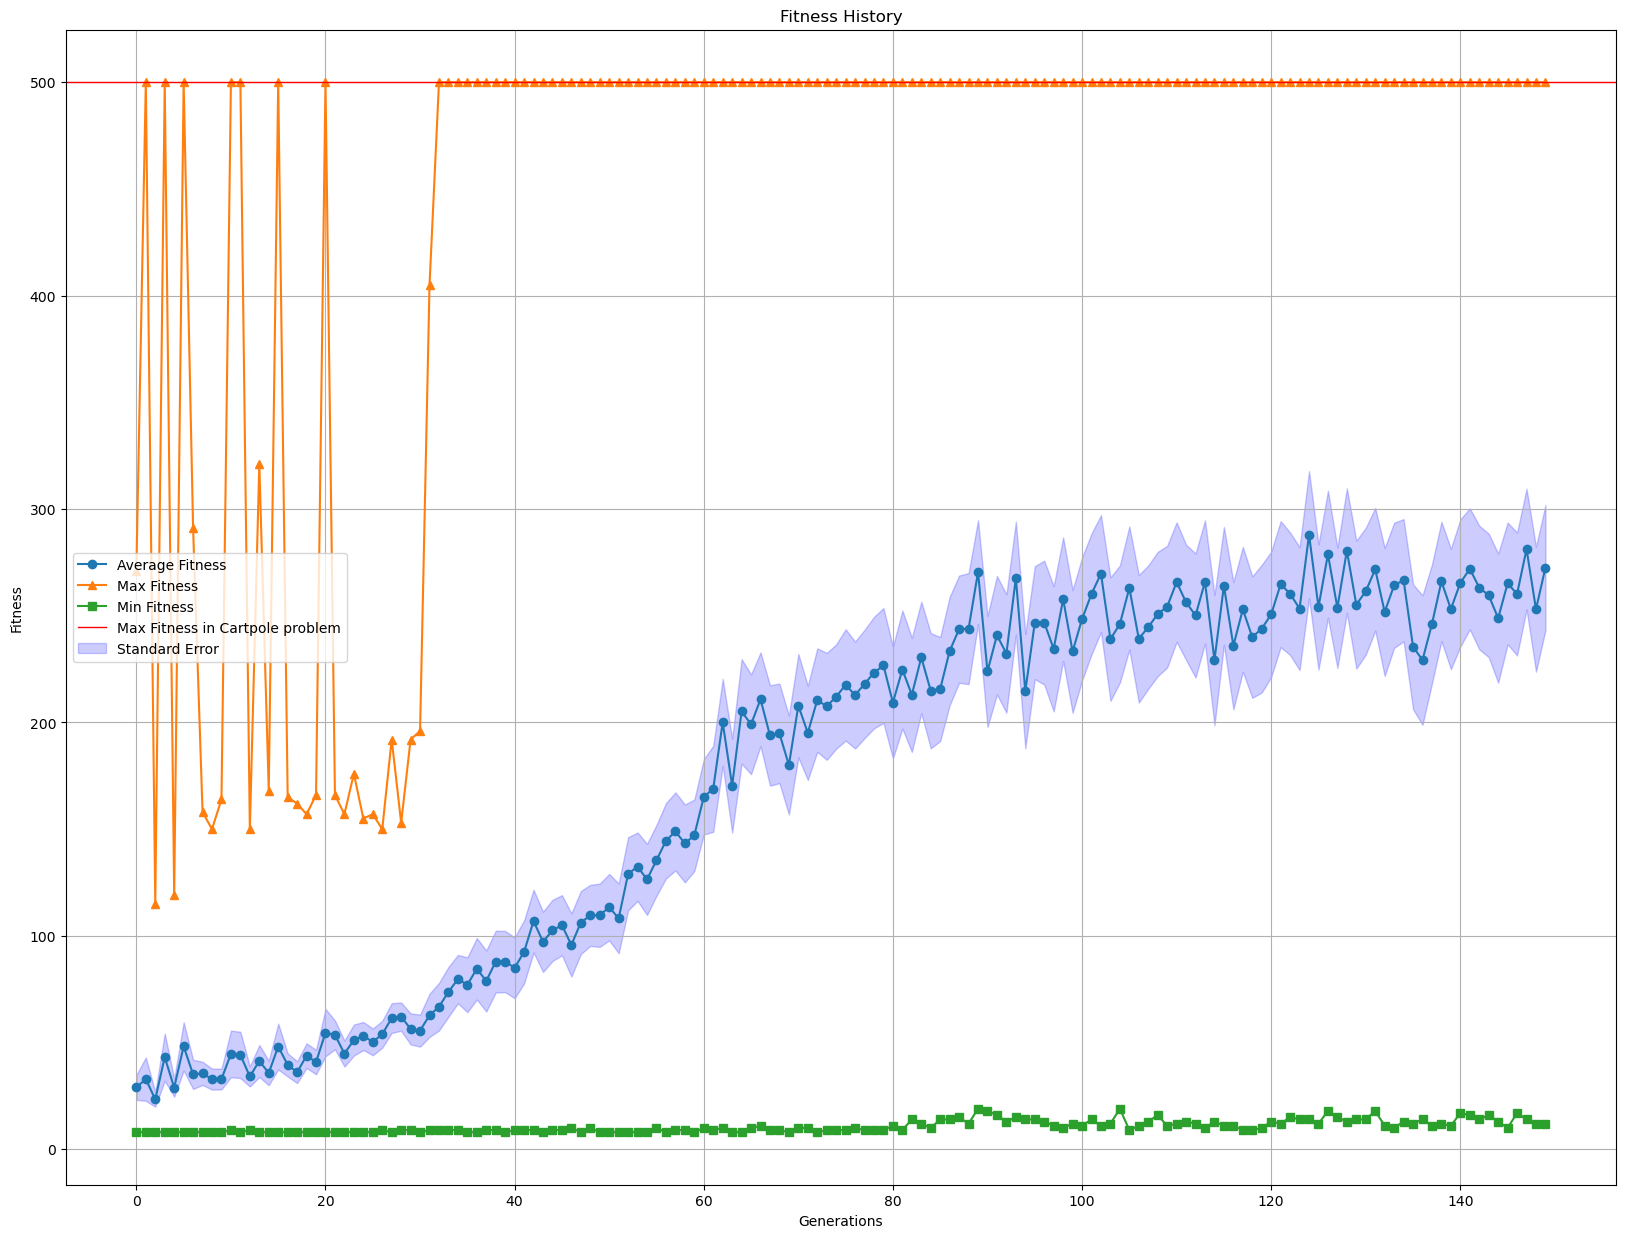

In [8]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.axhline(y=500, color='r', linewidth=1, label='Max Fitness in Cartpole problem')
plt.fill_between(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0] - np.array(FITNESS_STDERROR_HISTORY), np.array(FITNESS_HISTORY)[:,0] + np.array(FITNESS_STDERROR_HISTORY),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()

In [9]:
def visualize_best_individual(network, env):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        env.render()  # Render the environment to the screen
        action = network.act(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward
    print(f"Total reward: {total_reward}")
    env.close()

In [11]:
fitnesses = [calculate_fitness(network, env, MAX_EP) for network in tqdm(population, desc="Calculating fitnesses")]
population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
best_individual = population[0]
visualize_best_individual(best_individual, env)

Calculating fitnesses: 100%|████████████████████████████████| 50/50 [00:00<00:00, 159.28it/s]


error: display Surface quit